# Comb filter demo

## Import necessary code from repo

In [1]:
# First import code
import sys
sys.path.append('..')

In [2]:
from siggi import siggi, spectra, calcIG, plotting
from siggi.filters import filterFactory
from siggi import Sed
from siggi.lsst_utils import Bandpass, BandpassDict, PhotometricParameters
import matplotlib.pyplot as plt
import numpy as np
import os
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

In [3]:
import seaborn as sbs
sbs.set()

### Set up red and blue spectra

In [4]:
f = filterFactory.create_filter_object('comb')
f.set_wavelen_grid()
s = spectra()
red_spec = s.get_red_spectrum()
blue_spec = s.get_blue_spectrum()

In [5]:
def flat_prior_2(z):
    z_out = np.ones(len(z))
    z_out[0] = 0.
    return z_out

In [6]:
d_lambda = 25.
x = np.arange(375., 1026., d_lambda)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(387.5, 1026., d_lambda)
for val_1 in y:
    point_list.append([val_1, val_1])

In [7]:
bp_list = []
bp_dir = '../siggi/data/lsst_baseline_throughputs'
for filter_name in ['u', 'g', 'r', 'i', 'z', 'y']:
    current_bp = Bandpass()
    print(os.path.join(bp_dir, 'filter_%s.dat' % filter_name))
    current_bp.readThroughput(os.path.join(bp_dir, 'filter_%s.dat' % filter_name))
    bp_list.append(current_bp)

../siggi/data/lsst_baseline_throughputs/filter_u.dat
../siggi/data/lsst_baseline_throughputs/filter_g.dat
../siggi/data/lsst_baseline_throughputs/filter_r.dat
../siggi/data/lsst_baseline_throughputs/filter_i.dat
../siggi/data/lsst_baseline_throughputs/filter_z.dat
../siggi/data/lsst_baseline_throughputs/filter_y.dat


In [8]:
bp_dict = BandpassDict(bp_list, ['u', 'g', 'r', 'i', 'z', 'y'])

In [9]:
lsst_total_bp_dict = BandpassDict.loadTotalBandpassesFromFiles(bandpassDir=bp_dir)

In [10]:
new_phot_params = {}

new_phot_params['filter_0'] = PhotometricParameters(nexp=2, bandpass='any')
new_phot_params['g'] = PhotometricParameters(bandpass='g')

In [11]:
f_norm = red_spec.calcFluxNorm(22., bp_dict['i'])
red_spec.multiplyFluxNorm(f_norm)
f_norm = blue_spec.calcFluxNorm(22., bp_dict['i'])
blue_spec.multiplyFluxNorm(f_norm)

In [12]:
filt_edges = []
for point_loc in point_list:
    filt_edges.append([point_loc[0]-50., point_loc[0]+50., point_loc[1]-50., point_loc[1]+50.])

In [13]:
ig_vals = []
filt_edges = []
for point_loc in point_list:
    if len(ig_vals) % 50 == 0:
        print('%i out of %i' % (len(ig_vals), len(point_list)))
    filt_new = f.create_filter_dict_from_corners([[point_loc[0]-50., point_loc[0]-25., point_loc[0]+25., point_loc[0]+50.],
                                                  [point_loc[1]-50., point_loc[1]-25., point_loc[1]+25., point_loc[1]+50.]])
    filt_edges.append([point_loc[0]-50., point_loc[0]+50., point_loc[1]-50., point_loc[1]+50.])
    
    # Here we create a bandpass dictionary with g-band and the comb filter centered at the two test points
    filt_dict = BandpassDict([bp_dict['g'], filt_new['filter_0']], ['g', 'filter_0'])
    c = calcIG(filt_dict, [[red_spec], [blue_spec]], [0.0, 1.0, 1.0], [0, 1, 2], phot_params=new_phot_params, ref_filter=bp_dict['i'], n_pts=10000)
    ig_vals.append(c.calc_IG(rand_state=np.random.RandomState(42)))

0 out of 755
50 out of 755
100 out of 755
150 out of 755
200 out of 755
250 out of 755
300 out of 755
350 out of 755
400 out of 755
450 out of 755
500 out of 755
550 out of 755
600 out of 755
650 out of 755
700 out of 755
750 out of 755


### Make plots

In [14]:
max_idx = np.argmax(ig_vals)

best_pt = point_list[max_idx]

In [15]:
best_val = ig_vals[max_idx]

In [16]:
print(best_pt, best_val)

[500.0, 825.0] 0.9998333334507572


In [17]:
# Uncomment first line if higher wavelength comes first in best_pt
#best_pt = [best_pt[1], best_pt[0]]
best_filter = [best_pt[0]-50., best_pt[0]+50., best_pt[1]-50., best_pt[1]+50.]

In [18]:
sig_plot = plotting([red_spec, blue_spec], best_filter, 'comb',
                    frozen_filt_dict=BandpassDict([lsst_total_bp_dict['g']], ['g']), frozen_filt_eff_wavelen=[477], set_ratio=0.5,
                    sed_mags=22.0)

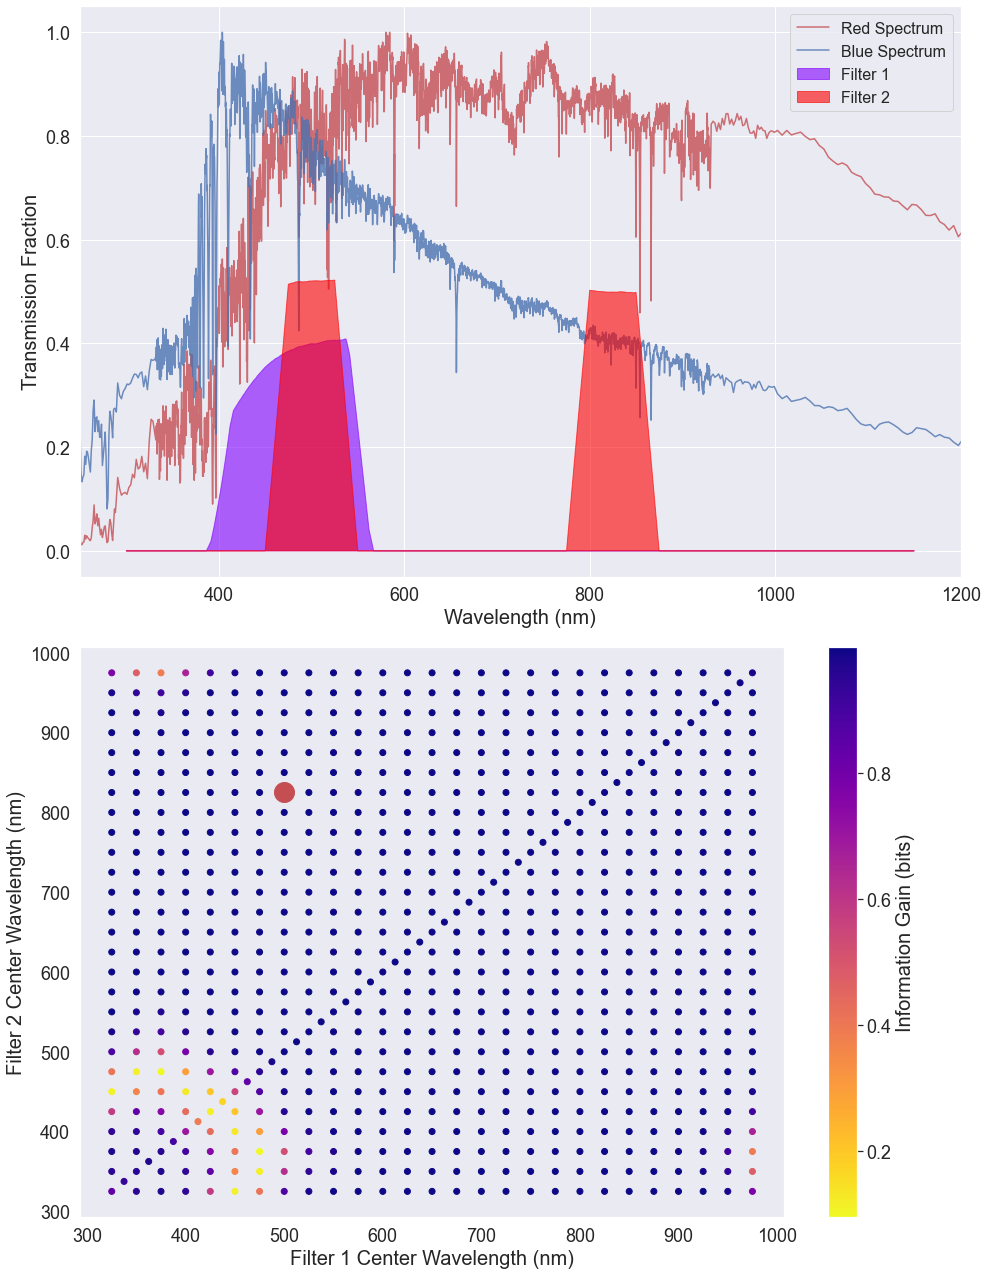

In [19]:
fig = plt.figure(figsize=(14, 18))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
ax.lines[0].set_color('r')
ax.lines[1].set_color('b')
ax.lines[0].set_alpha(0.8)
ax.lines[1].set_alpha(0.8)
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Red Spectrum', 'Blue Spectrum', 'Filter 1', 'Filter 2'), loc=1, fontsize=16)
plt.xticks(size=18)
plt.yticks(size=18)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
#sig_plot.plot_ig_space(np.array(filt_edges), np.array(ig_vals), [0,1])
plt.scatter(np.array(filt_edges)[:,0], np.array(filt_edges)[:,2], c=np.array(ig_vals),
            cmap=plt.get_cmap('plasma_r'))
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)', size=20)
cbar.ax.tick_params(labelsize=18)
plt.scatter(best_pt[0], best_pt[1], c='r', s=400)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.grid(False)
plt.tight_layout()
#plt.savefig('Example_1.pdf')

## Make a comb filter from scratch

In [20]:
comb_filt = filterFactory.create_filter_object('comb')

In [21]:
comb_filt.set_wavelen_grid()

In [22]:
set_ratio = 1.0
set_width = 20
comb_dict = comb_filt.create_filter_dict_from_shape_params(set_ratio, set_width, [400., 600., 800.])
comb_dict._bandpassDict['filter_1'] = comb_dict['filter_0']
del(comb_dict._bandpassDict['filter_0'])

Text(0, 0.5, 'Transmission Fraction')

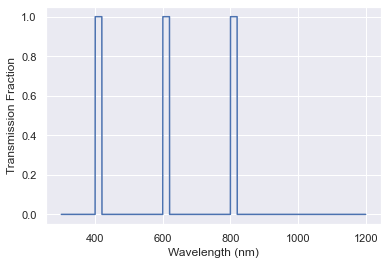

In [23]:
plt.plot(comb_dict['filter_1'].wavelen,
         comb_dict['filter_1'].sb)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmission Fraction')

In [24]:
hardware_filt_dict, total_filt_dict = BandpassDict.addSystemBandpass(comb_dict)

In [25]:
comb_filt.find_filt_centers(total_filt_dict)

[614.2000000000714]

## Use comb filter as frozen filter

In [26]:
red_spec = s.get_red_spectrum()

In [27]:
new_phot_params = {}

new_phot_params['filter_0'] = PhotometricParameters(nexp=2, bandpass='any')
new_phot_params['filter_1'] = PhotometricParameters(nexp=2, bandpass='any')

In [28]:
def prior_z(z, z0=0.552):
    return (z**2.)*np.exp(-(z/z0)**2)/(np.sum((np.arange(0, 2.51, .05)**2.)*np.exp(-(np.arange(0, 2.51, .05)/z0)**2.)))

In [29]:
sig_example = siggi([red_spec], [1.0], prior_z,
                    z_min=0.00, z_max=2., z_steps=41, phot_params=new_phot_params, calib_mag=22.)

In [30]:
%%time
test_rand_state = np.random.RandomState(864)
num_filters = 3
set_ratio = 1.0
set_width = 20
res_3 = sig_example.optimize_filters(num_filters=num_filters, filt_type='comb',
                                     filt_min=300., filt_max=1100.,
                                     set_ratio=set_ratio,
                                     set_width=set_width,
                                     system_wavelen_max=1200.,
                                     n_opt_points=160,
                                     optimizer_verbosity=5,
                                     procs=4,
                                     frozen_filt_dict = total_filt_dict,
                                     frozen_filt_eff_wavelen=[614.2],
                                     starting_points = [[500, 700, 900], [300, 500, 700]],
                                     rand_state=test_rand_state)

[[500, 700, 900], [300, 500, 700], [300.0, 690.0, 1080.0], [566.6666666666667, 823.3333333333334, 1080.0], [833.3333333333334, 956.6666666666667, 1080.0], [527.7605162352752, 799.8532938156711, 1063.4248209520256], [341.54389462383097, 358.15864203950787, 742.4563787023152], [322.1119148146769, 483.8505980283147, 771.9341900626298], [491.50542506785905, 516.713068074049, 563.5376706494799], [339.69728026414157, 490.148600823072, 711.6956287713354]]


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:   18.5s remaining:   12.3s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   29.9s finished


-1.1960327089051468 10
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.3s remaining:    6.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.5s finished


-1.2193147892110954 14
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.0s finished


-1.2193147892110954 18
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.6s remaining:    7.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.1s finished


-1.2193147892110954 22
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.5s remaining:    7.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.9s finished


-1.2193147892110954 26
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.6s remaining:    6.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.9s finished


-1.2193147892110954 30
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.5s finished


-1.2193147892110954 34
4
5
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.3s remaining:    6.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.4s finished


-1.2193147892110954 38
4
5
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   10.6s remaining:   10.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.7s finished


-1.2193147892110954 42
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.4s finished


-1.2193147892110954 46
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.4s remaining:    6.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.7s finished


-1.2193147892110954 50
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.3s remaining:    6.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.4s finished


-1.2193147892110954 54
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    9.8s remaining:    9.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.9s finished


-1.2193147892110954 58
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.7s remaining:    7.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.0s finished


-1.2193147892110954 62
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.3s remaining:    8.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.5s finished


-1.2193147892110954 66
4
5
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.8s finished


-1.2193147892110954 70
4
5
6
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.6s remaining:    7.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.9s finished


-1.2193147892110954 74
4
5
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.8s finished


-1.2193147892110954 78
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.9s remaining:    5.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.1s finished


-1.2193147892110954 82
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.1s finished


-1.2193147892110954 86
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.6s remaining:    7.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.7s finished


-1.2193147892110954 90
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.2s remaining:    6.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.4s finished


-1.2193147892110954 94
4
5
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.8s remaining:    5.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.0s finished


-1.2193147892110954 98
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.4s remaining:    6.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.6s finished


-1.2193147892110954 102
4
5
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.4s remaining:    6.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.8s finished


-1.2193147892110954 106
4
5
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.2s remaining:    6.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.4s finished


-1.2193147892110954 110
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.7s remaining:    5.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.0s finished


-1.2193147892110954 114
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.3s finished


-1.2193147892110954 118
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.1s remaining:    6.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.2s finished


-1.2193147892110954 122
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.3s remaining:    6.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.5s finished


-1.2193147892110954 126
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.8s remaining:    5.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.9s finished


-1.2193147892110954 130
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.8s remaining:    7.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.2s finished


-1.2193147892110954 134
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.2s finished


-1.2193147892110954 138
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.5s remaining:    6.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.6s finished


-1.2193147892110954 142
4
5
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.8s remaining:    5.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.1s finished


-1.2193147892110954 146
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.3s remaining:    7.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.4s finished


-1.2193147892110954 150
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.1s remaining:    6.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.3s finished


-1.2193147892110954 154
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    9.7s remaining:    9.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.9s finished


-1.2193147892110954 158
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.6s remaining:    6.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.8s finished


-1.2193147892110954 162
CPU times: user 10min 58s, sys: 28.1 s, total: 11min 26s
Wall time: 14min


In [31]:
min_idx = np.argmin(res_3.yi)
best_pt = res_3.Xi[min_idx]
print(best_pt, res_3.yi[min_idx])

[525.5753058187709, 502.64244535684327, 560.5898800831139] -1.2193147892110954


In [32]:
test_red_spec = s.get_red_spectrum()
test_red_spec.redshiftSED(0.55)

In [33]:
sig_plot = plotting([red_spec, test_red_spec], best_pt, 'comb',
                    frozen_filt_dict=total_filt_dict, frozen_filt_eff_wavelen=[610], 
                    set_ratio=set_ratio, set_width=set_width,
                    sed_mags=22.0)

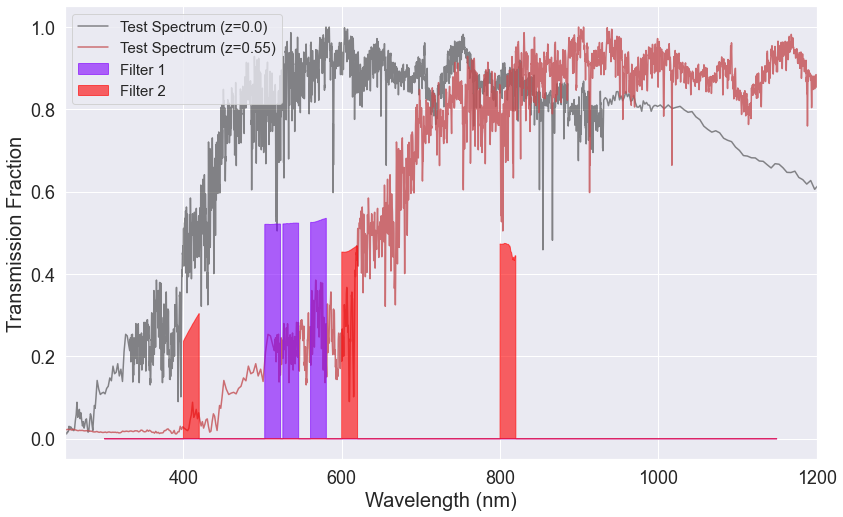

In [34]:
fig = plt.figure(figsize=(12, 14))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
ax = plt.gca()
#ax.lines[0].set_color('r')
ax.lines[1].set_color('r')
#ax.lines[0].set_alpha(0.8)
ax.lines[1].set_alpha(0.8)
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Test Spectrum (z=0.0)', 'Test Spectrum (z=0.55)', 'Filter 1', 'Filter 2'), loc=2, fontsize=15)
plt.xticks(size=18)
plt.yticks(size=18)
# fig.add_subplot(2,1,2)
# plt.rcParams.update({'font.size': 16})
# sig_plot.plot_ig_space(res_3.Xi[:-3], np.abs(res_3.yi[:-3]), [0,1])
# cbar = plt.colorbar()
# cbar.set_label('Information Gain (bits)', size=20)
# cbar.ax.tick_params(labelsize=18)
# plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=400)
# plt.scatter(475., 525., c='c', s=400)
# plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
# plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
# plt.xticks(size=18)
# plt.yticks(size=18)
# plt.grid(False)
plt.tight_layout()
#plt.savefig('Example_3.pdf')

## Use with LSST filters

In [35]:
lsst_centers = comb_filt.find_filt_centers(lsst_total_bp_dict)

In [36]:
new_phot_params = {}

new_phot_params['filter_0'] = PhotometricParameters(nexp=2, bandpass='any')
new_phot_params['u'] = PhotometricParameters(bandpass='u')
new_phot_params['g'] = PhotometricParameters(bandpass='g')
new_phot_params['r'] = PhotometricParameters(bandpass='r')
new_phot_params['i'] = PhotometricParameters(bandpass='i')
new_phot_params['z'] = PhotometricParameters(bandpass='z')
new_phot_params['y'] = PhotometricParameters(bandpass='y')

In [37]:
sig_example = siggi([red_spec], [1.0], prior_z,
                    z_min=0.00, z_max=2., z_steps=41, phot_params=new_phot_params, calib_mag=22.)

In [38]:
%%time
test_rand_state = np.random.RandomState(864)
num_filters = 3
set_ratio = 1.0
set_width = 20
res_3 = sig_example.optimize_filters(num_filters=num_filters, filt_type='comb',
                                     filt_min=300., filt_max=1100.,
                                     set_ratio=set_ratio,
                                     set_width=set_width,
                                     system_wavelen_max=1200.,
                                     n_opt_points=110,
                                     optimizer_verbosity=5,
                                     procs=4,
                                     frozen_filt_dict = lsst_total_bp_dict,
                                     frozen_filt_eff_wavelen=lsst_centers,
                                     starting_points = [[500, 700, 900], [300, 500, 700]],
                                     rand_state=test_rand_state)

[[500, 700, 900], [300, 500, 700], [300.0, 690.0, 1080.0], [566.6666666666667, 823.3333333333334, 1080.0], [833.3333333333334, 956.6666666666667, 1080.0], [527.7605162352752, 799.8532938156711, 1063.4248209520256], [341.54389462383097, 358.15864203950787, 742.4563787023152], [322.1119148146769, 483.8505980283147, 771.9341900626298], [491.50542506785905, 516.713068074049, 563.5376706494799], [339.69728026414157, 490.148600823072, 711.6956287713354]]


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:   49.1s remaining:   32.7s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.0min finished


-4.400608968697589 10
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   21.2s remaining:   21.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   21.3s finished


-4.400608968697589 14
4
5
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   15.5s remaining:   15.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.6s finished


-4.400624734368113 18
4
5
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   14.7s remaining:   14.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.9s finished


-4.400624734368113 22
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   17.1s remaining:   17.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.5s finished


-4.400624734368113 26
4
5
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   16.5s remaining:   16.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.7s finished


-4.400635489873649 30
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   14.6s remaining:   14.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.7s finished


-4.400635489873649 34
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   17.6s remaining:   17.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.9s finished


-4.400635489873649 38
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   15.3s remaining:   15.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.5s finished


-4.400635489873649 42
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   16.9s remaining:   16.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.2s finished


-4.400635489873649 46
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   15.7s remaining:   15.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.0s finished


-4.400635489873649 50
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   16.9s remaining:   16.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.5s finished


-4.400635489873649 54
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   15.4s remaining:   15.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.5s finished


-4.400635489873649 58
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   17.2s remaining:   17.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.4s finished


-4.400638685383911 62
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   16.1s remaining:   16.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.2s finished


-4.400638685383911 66
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   24.4s remaining:   24.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.6s finished


-4.400644772318864 70
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   24.4s remaining:   24.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.4s finished


-4.400644772318864 74
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   18.0s remaining:   18.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   18.2s finished


-4.400644772318864 78
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   15.6s remaining:   15.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.8s finished


-4.400644772318864 82
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   21.2s remaining:   21.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   21.4s finished


-4.400644772318864 86
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   14.0s remaining:   14.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.3s finished


-4.400644772318864 90
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   14.2s remaining:   14.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.5s finished


-4.400644772318864 94
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   13.8s remaining:   13.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.1s finished


-4.400644772318864 98
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   15.2s remaining:   15.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.2s finished


-4.400644772318864 102
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   14.3s remaining:   14.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.4s finished


-4.400644772318864 106
4
Random Points Used: 0


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   28.7s remaining:   28.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   28.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   28.8s finished


-4.400644772318864 110
CPU times: user 5min 9s, sys: 13.6 s, total: 5min 23s
Wall time: 12min 21s


In [39]:
min_idx = np.argmin(res_3.yi)
best_pt = res_3.Xi[min_idx]
print(best_pt, res_3.yi[min_idx])

[815.1803790419689, 397.642281821998, 300.0] -4.400644772318864


In [40]:
test_red_spec = s.get_red_spectrum()
test_red_spec.redshiftSED(0.55)

In [41]:
sig_plot = plotting([red_spec, test_red_spec], best_pt, 'comb',
                    frozen_filt_dict=lsst_total_bp_dict, frozen_filt_eff_wavelen=lsst_centers, 
                    set_ratio=set_ratio, set_width=set_width,
                    sed_mags=22.0)

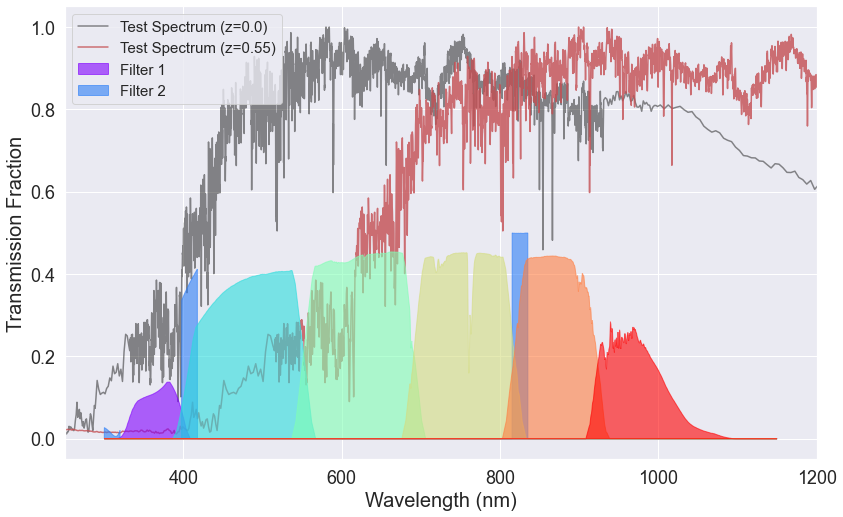

In [42]:
fig = plt.figure(figsize=(12, 14))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
ax = plt.gca()
#ax.lines[0].set_color('r')
ax.lines[1].set_color('r')
#ax.lines[0].set_alpha(0.8)
ax.lines[1].set_alpha(0.8)
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Test Spectrum (z=0.0)', 'Test Spectrum (z=0.55)', 'Filter 1', 'Filter 2'), loc=2, fontsize=15)
plt.xticks(size=18)
plt.yticks(size=18)
# fig.add_subplot(2,1,2)
# plt.rcParams.update({'font.size': 16})
# sig_plot.plot_ig_space(res_3.Xi[:-3], np.abs(res_3.yi[:-3]), [0,1])
# cbar = plt.colorbar()
# cbar.set_label('Information Gain (bits)', size=20)
# cbar.ax.tick_params(labelsize=18)
# plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=400)
# plt.scatter(475., 525., c='c', s=400)
# plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
# plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
# plt.xticks(size=18)
# plt.yticks(size=18)
# plt.grid(False)
plt.tight_layout()
#plt.savefig('Example_3.pdf')